In [1]:
#
# Working through
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_7_conc_input_conf_k_aug.py
#

In [2]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [5]:
filename = 'ABC_data.csv'
D_frame = read_file(filename, directory = '../my_data_sets')

read dir : /home/paperspace/learn_kipet/kipet_examples/../my_data_sets/ABC_data.csv


In [6]:
D_frame.shape

(20, 3)

In [39]:
D_frame.columns = ['A', 'B', 'C']
D_frame

,A,B,C
t,,,
0.000,0.957,0.000,0.000
0.263,0.557,0.330,0.044
0.526,0.342,0.512,0.156
0.789,0.224,0.499,0.310
1.053,0.123,0.428,0.454
1.316,0.079,0.396,0.556
1.579,0.035,0.303,0.651
1.842,0.029,0.287,0.658
2.105,0.025,0.221,0.750


In [40]:
builder = TemplateBuilder()    
components = {'A':1,'B':0,'C':0}
builder.add_mixture_component(components)
builder.add_parameter('k1',initialize = 5.0, bounds=(0.0,10.0))
builder.add_parameter('k2',initialize = 5.0, bounds=(0.0,10.0))
builder.add_concentration_data(D_frame)

In [41]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs

builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,5.0)

In [42]:
#sigmas = {'A':1e-10,'B':1e-11,'C':1e-8}
sigmas = {'A':1, 'B':1, 'C':1}
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=50,ncp=3,scheme='LAGRANGE-RADAU')

In [47]:
options = dict()
results_pyomo = p_estimator.run_opt('k_aug',
                                    variances=sigmas,
                                  tee=True,
                                  solver_opts = options,
                                  covariance=True)

        0.11 seconds required to write file
        0.11 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3903
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      905
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
T

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018

: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 905
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 2
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.600850723619365 at var_i=300
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.600935073760363 at var_i=301
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 3903
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 360
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.022670
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 845
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG

In [48]:
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 2.018094438277291
k2 0.9931213751559862


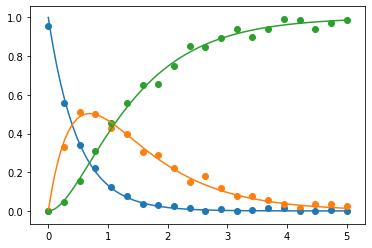

In [49]:
fig, ax = plt.subplots()
for c in ['A', 'B', 'C']:
    ax.scatter(D_frame.index, D_frame[c])
    ax.plot(results_pyomo.Z.index, results_pyomo.Z[c])

In [50]:
results_pyomo.objective

0.02267025069803104

In [51]:
results_pyomo.parameter_covariance

array([[ 2.56052478, -0.39125335],
       [-0.39125335,  0.34541696]])

In [54]:
mse = results_pyomo.objective / (30*3 - 2)
rmse = np.sqrt(mse)
rmse

0.016050435670252012

In [55]:
cov_est = 2 * mse * results_pyomo.parameter_covariance
cov_est

array([[ 0.00131927, -0.00020159],
       [-0.00020159,  0.00017797]])